In [16]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import emcee
import batman
import sys

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
ls

ajplanet.so      EPIC-9792_SOPHIE.rdb  keplerian.py  RV_transit_curves.ipynb
BLS.ipynb        fit_transit.ipynb     libgsl.so.0
cuttransits.txt  get_rvN.so            MCMC.ipynb
environment.yml  GLS.ipynb             README.md


In [18]:
# you need to have exonailer installed
# append to sys.path the directory where you find the file 'ajplanet.so'
sys.path.append('..')
from ajplanet import pl_rv_array as rv_curve

In [19]:
# fix the eccentricity (to zero)
fix_ecc = True

In [20]:
class Planet(object):
    def __init__(self):
        # these are fixed
        self.limb_dark = "quadratic" # limb darkening model
        self.u = [.4983, 0.2042]     # limb darkening coefficients
        
        # transit parameters
        self.rp = 0.          # planet radius (in units of stellar radii)
        self.a = 0.           # semi-major axis (in units of stellar radii)
        self.inc = 0.         # orbital inclination (in degrees)
        self.t0 = 0.          # time of inferior conjunction
        self.jitter_lc = 0.

        # rv parameters
        self.rvsys = 0.      # radial velocity systematic velocity
        self.K = 0.          # semi-amplitude
        self.T0 = 0.         # time of periastron (function of self.t0, not a free parameter)
        self.jitter_rv = 0.

        # parameters shared between transit and rv
        self.period = 0. # orbital period
        self.ecc = 0.    # eccentricity
        self.w = 0.      # longitude of periastron (in degrees)

        
        # number of free parameters        
        self.N_free_parameters = 9


        # start the batman model
        self.params = batman.TransitParams()
        self.params.limb_dark = self.limb_dark  # limb darkening model
        self.params.u = self.u                  # limb darkening coefficients

        # names of the parameters for the plots
        self.labels = [r'$R_p / R_*$',
                       r'$a/R_*$',
                       r'$i$',
                       r'$t_0$',
                       r'$s_{\rm lc}$',
                       'vsys',
                       r'$K$',
                       r'$s_{\rm RV}$',
                       r'$P$',
                       r'$e$',
                       r'$\omega$']
        
        if fix_ecc:
            self.labels.pop(10)
            self.labels.pop(9)


    def set_rv_parameters(self, pars):
        """ pars should be [rvsys, K, jitter_rv] """
        self.rvsys, self.K, self.jitter_rv = pars


    def set_transit_parameters(self, pars):
        """ pars should be [rp, a, inc, t0, jitter_lc] """
        self.rp, self.a, self.inc, self.t0, self.jitter_lc = pars

        
    def set_shared_parameters(self, pars):
        """ pars should be [period, (ecc, w)] """
        if fix_ecc:
            self.period = pars
            self.ecc = 0.
            self.w = 90.
        else:
            self.period, self.ecc, self.w = pars
        
        self.T0 = self.t0 # set the time of periastron
        

    def get_rv_curve(self, t, debug=False):
        """ return the RV curve evaluated at times t """
        return rv_curve(t,
                        self.rvsys, self.K, np.deg2rad(self.w),
                        self.ecc, self.T0, self.period)

    
    def get_transit_curve(self, t, debug=False):
        """ return the transit curve at times t"""
        
        # set self.params for batman
        self.params.t0 = self.t0
        self.params.per = self.period
        self.params.rp = self.rp
        self.params.a = self.a
        self.params.inc = self.inc
        self.params.ecc = self.ecc
        self.params.w = self.w

        self.batman_model = batman.TransitModel(self.params, t)
        light_curve = self.batman_model.light_curve(self.params)
        
        return light_curve


    def set_priors(self):
        """ Define each parameter prior distribution """
        
        # use the scipy distributions!
        self.prior_rp = stats.norm(0.13169205, 0.001124) # planet radius (in units of stellar radii)
        self.prior_a = stats.norm(10.7256256, 0.289662)  # semi-major axis (in units of stellar radii)
        self.prior_inc = stats.uniform(80, 10)           # orbital inclination (in degrees)
        self.prior_t0 = stats.norm(57064.4327, 0.000144) # time of inferior conjunction
        self.prior_jitter_lc = stats.reciprocal(0.001, 0.1) 

        # rv parameters
        self.prior_rvsys = stats.uniform(32.86, 0.02)                            # systematic radial velocity
        self.prior_K = stats.uniform(80e-3, 50e-3)                                # semi-amplitude
        self.prior_jitter_rv = stats.reciprocal(0.1e-3, 30e-3)
 
        # parameters shared between transit and rv
        self.prior_period = stats.norm(3.25872421, 1.83e-05)                           # orbital period
        
        if not fix_ecc:
            self.prior_ecc = stats.uniform(0, 1)                     # eccentricity
            self.prior_w = stats.uniform(0, 360)                     # longitude of periastron (in degrees)


    def get_from_prior(self, nwalkers):
        """ return a list with random values from each parameter's prior """       
        self.set_priors()

        pars_from_prior = []
        for i in range(nwalkers):
            # use again the scipy distributions
            random_rp = self.prior_rp.rvs()
            random_a = self.prior_a.rvs()
            random_inc = self.prior_inc.rvs()
            random_t0 = self.prior_t0.rvs()
            random_jitter_lc = self.prior_jitter_lc.rvs()
            
            random_rvsys = self.prior_rvsys.rvs()
            random_K = self.prior_K.rvs()
            random_jitter_rv = self.prior_jitter_rv.rvs()
            
            random_period = self.prior_period.rvs()
            
            pars_from_prior.append([random_rp,random_a, random_inc, random_t0, random_jitter_lc,
                                    random_rvsys, random_K, random_jitter_rv,
                                    random_period])

            if not fix_ecc:
                random_ecc = self.prior_ecc.rvs()
                random_w = self.prior_w.rvs()
                
                pars_from_prior.append(random_ecc, random_w)

        return pars_from_prior

In [21]:
### A very simple Data class to hold the light curve and the RVs
class Data(object):
    def __init__(self, rv_file, lc_file, skip_rv_rows=2, skip_lc_rows=0):
        
        self.rv_file = rv_file
        self.lc_file = lc_file

        # read RVs
        self.RVtime, self.RV, self.RVerror = np.loadtxt(rv_file, 
                                                        unpack=True, skiprows=skip_rv_rows)

        # read light curve
        self.LCtime, self.LC, self.LCerror = np.loadtxt(lc_file,
                                                        unpack=True, skiprows=skip_lc_rows)

        self.N_rvs = self.RVtime.size
        self.N_lc = self.LCtime.size

In [22]:
### This is the log likelihood function

def lnlike(pars, planet, data, debug=False):
    """ pars should be
    # [rp, a, inc, t0, jitter_lc,
    #  rvsys, K, jitter_rv,
    #  period, ecc, w]
    """
    log2pi = np.log(2*np.pi)


    # set the transit params
    planet.set_transit_parameters(pars[:5])
    # set the RV params
    planet.set_rv_parameters(pars[5:8])
    # set the shared params
    planet.set_shared_parameters(pars[8:])

    
    # calculate the lnlike for transit (eq. 3)
    transit_model = planet.get_transit_curve(data.LCtime)
    sigma = data.LCerror**2 + planet.jitter_lc**2
    chi = np.log(sigma)/2. + (data.LC - transit_model)**2 / (2.*sigma)
    
    log_like_transit = - 0.5*data.N_lc*log2pi - np.sum(chi)
    
    # if you want, try to calculate lnlike using one of the scipy distributions
    # we did from scipy import stats
    log_like_transit2 = stats.norm(loc=transit_model, scale=sigma).logpdf(data.LC).sum()
    
    
    
    # calculate the lnlike for RVs
    rv_model = planet.get_rv_curve(data.RVtime)
    sigma = data.RVerror**2 + planet.jitter_rv**2
    chi = np.log(sigma)/2. + (data.RV - rv_model)**2 / (2*sigma)
    log_like_rv = - 0.5*data.N_rvs*log2pi - np.sum(chi)


    
    # the total log likelighood 
    log_like = log_like_transit + log_like_rv
    
    
    if not np.isfinite(log_like):
        return -np.inf
    else:
        return log_like

In [23]:
### This function calculate the log prior for a set of parameters
def lnprior(pars, planet, data, debug=False):
    """ pars should be
    # [rp, a, inc, t0, jitter_lc,
    #  rvsys, K, jitter_rv,
    #  period, ecc, w]
    """

    # transit parameters
    prior_rp = planet.prior_rp.logpdf(pars[0])
    prior_a = planet.prior_a.logpdf(pars[1])
    prior_inc = planet.prior_inc.logpdf(pars[2])
    prior_t0 = planet.prior_t0.logpdf(pars[3])
    prior_jitter_lc = planet.prior_jitter_lc.logpdf(pars[4])
    
    # rv parameters
    prior_rvsys = planet.prior_rvsys.logpdf(pars[5])
    prior_K = planet.prior_K.logpdf(pars[6])
    prior_jitter_rv = planet.prior_jitter_rv.logpdf(pars[7])

    # parameters shared between transit and rv
    prior_period = planet.prior_period.logpdf(pars[8])

    
    # total log prior
    ln_prior = prior_rp + prior_a + prior_inc + prior_t0 + prior_jitter_lc \
                + prior_rvsys + prior_K + prior_jitter_rv \
                + prior_period

    
    if not fix_ecc:
        prior_ecc = 0.
        prior_w = 0.

        # change ln_prior
        # add prior_ecc and prior_w to ln_prior.....

    return ln_prior

In [24]:
### posterior distribution
def lnprob(pars, planet, data, debug=True):
    log_prior = lnprior(pars, planet, data)
    log_like = lnlike(pars, planet, data)
    log_posterior = log_prior + log_like
    return log_posterior

In [25]:
### initialize the Planet and Data classes
planet = Planet()
data = Data(rv_file='EPIC-9792_SOPHIE.rdb', lc_file='cuttransits.txt')

In [26]:
### parameters for emcee
ndim, nwalkers = planet.N_free_parameters, 30

In [27]:
# get random starting positions from the priors
pos = planet.get_from_prior(nwalkers)

In [28]:
# sample the posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(planet, data))

nsteps = 50
out = sampler.run_mcmc(pos, nsteps)

In [29]:
## optionally remove some of the initial steps
burnin = 0
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

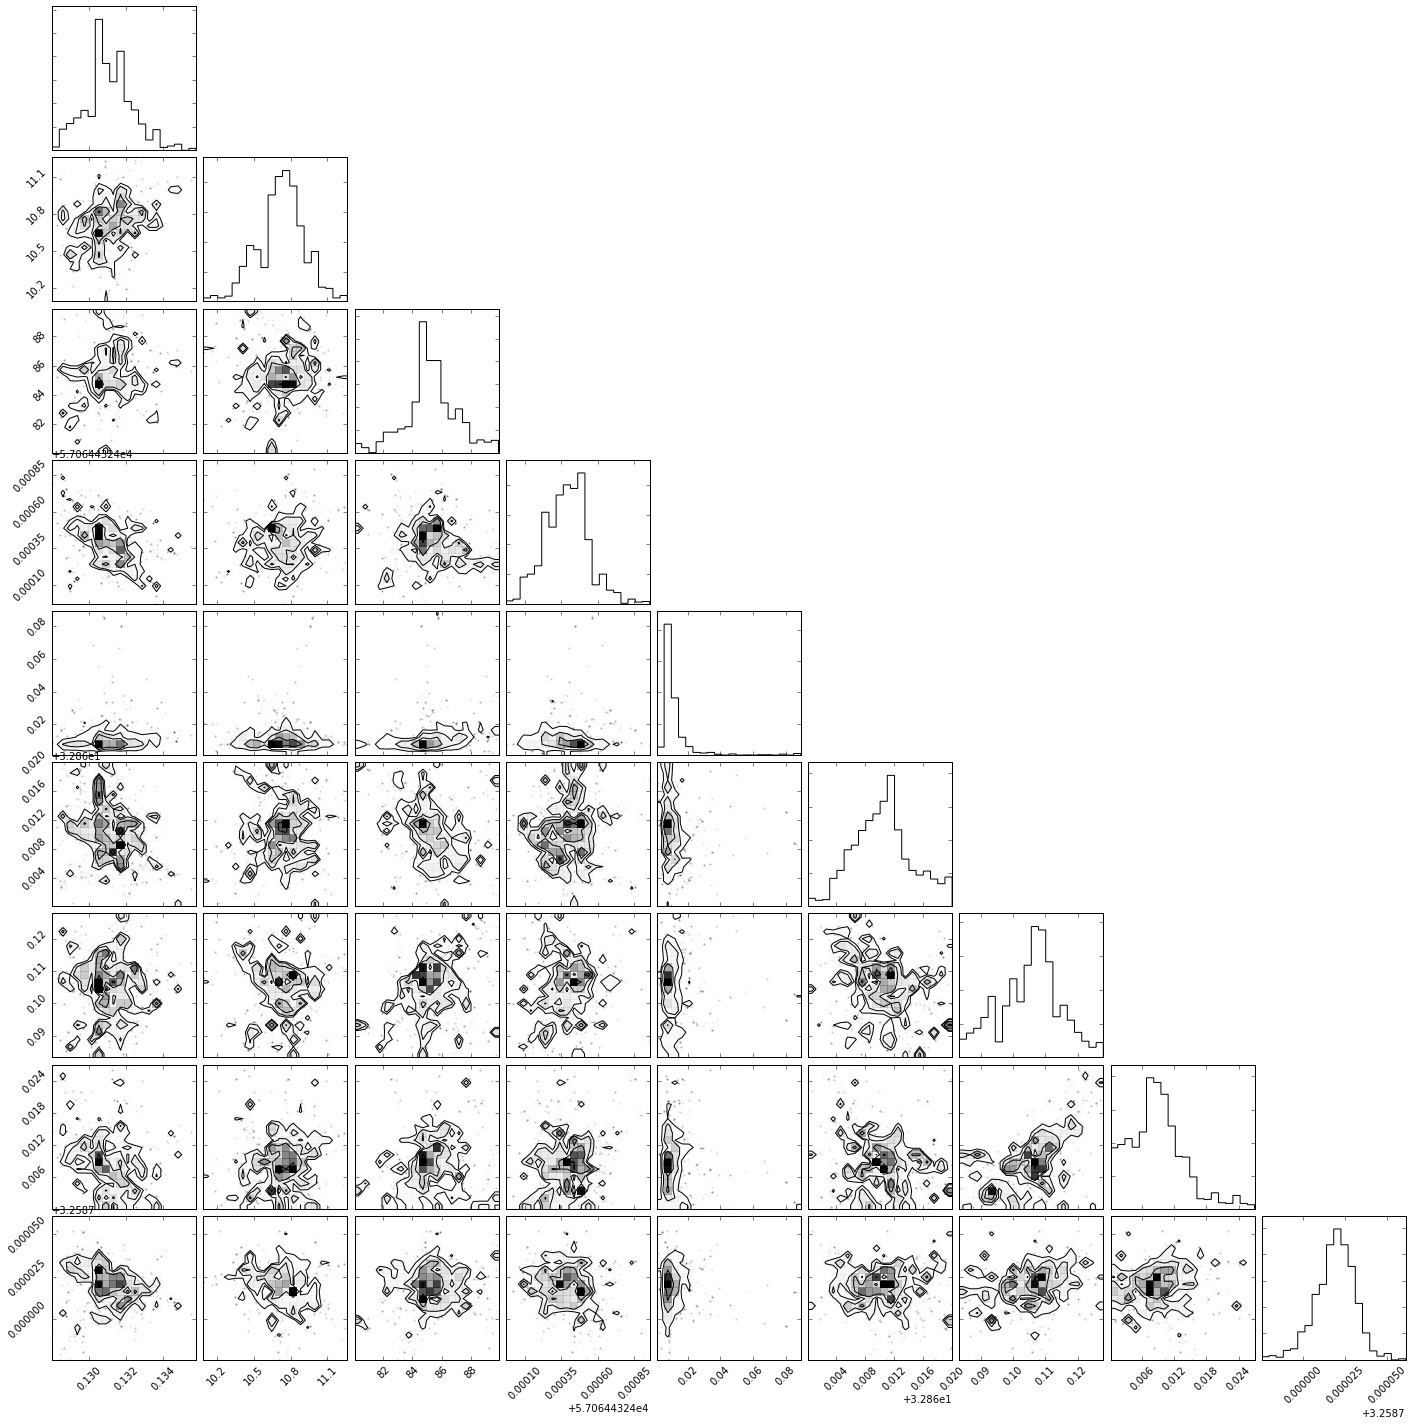

In [30]:
## make a corner plot of the MCMC samples
import corner

corner.corner(samples)
plt.show()

In [31]:
## get the medians of the posterior distributions
median_pars = np.median(samples, axis=0)


print ['%8s' % s.replace('$', '').replace('_', '').replace('\\rm', '').replace('\\','') for s in planet.labels]
print ['%8.4f' % s for s in median_pars]

[' Rp / R*', '    a/R*', '       i', '      t0', '  s{ lc}', '    vsys', '       K', '  s{ RV}', '       P']
['  0.1311', ' 10.7361', ' 85.2341', '57064.4328', '  0.0092', ' 32.8703', '  0.1065', '  0.0084', '  3.2587']


In [32]:
# set the transit params
planet.set_transit_parameters(median_pars[:5])
# set the RV params
planet.set_rv_parameters(median_pars[5:8])
# set the shared params
planet.set_shared_parameters(median_pars[8:])

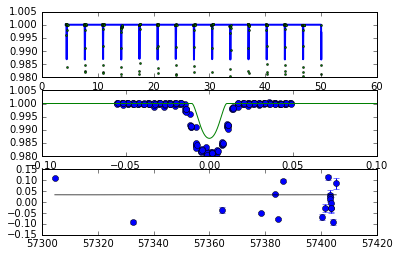

In [33]:
fig = plt.figure()

#
time = np.linspace(data.LCtime.min(), data.LCtime.max(), 5000)
lc = planet.get_transit_curve(time)

ax = fig.add_subplot(311)
ax.plot(time, lc, lw=2)
ax.plot(data.LCtime, data.LC, 'o', ms=2)

#
phase0 = (data.LCtime - planet.t0) / planet.period
phase = phase0 % 1
phase[np.where(phase>0.5)[0]]-=1

ax = fig.add_subplot(312)
ax.plot(phase, data.LC, 'o')

#
phase = ((time - planet.t0) / planet.period) % 1
phase[np.where(phase>0.5)[0]]-=1
LCfold = lc[np.argsort(phase)]

ax.plot(np.sort(phase), LCfold, '-')
ax.set_xlim([-0.1, 0.1])

#
time = np.linspace(data.RVtime.min(), data.RVtime.max(), 1000)
rv = planet.get_rv_curve(time)

ax = fig.add_subplot(313)
ax.errorbar(data.RVtime, data.RV - median_pars[5], data.RVerror, fmt='o')
ax.plot(time, rv*1e-3, 'k', alpha=0.7)


plt.show()